# Setup

In [1]:
import json
import pprint
import numpy as np
from contextlib import redirect_stdout
import io
from network_computation import compute_functional_network
from utilities_network import plot_network, animate_networks

# Data

Active slice (here, [1300,2300]) of each quantity of each sensor.

- Inititally stored as a dictionary.
- First level: 5 sensors ('OR', 'OL', 'IB', 'IT', 'IL')
- Second level: 19 quantities ('time', 'ax', 'ay', 'az', 'phi', 'theta', 'psi', 'wx', 'wy', 'wz', 'Ax', 'Ay', 'Az', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz')

In [2]:
# Data was saved as a dictionary using experiment_save_data.py.
# To regenerate the data (use different experiment data or different active slice other than [1300-2300]),
# Go to experiments directory and run in python:
    # python experiment_save_data.py

with open("../../experiments/data_2025-09-03 Euler Angles_20250903_203926.json", 'r') as f:
    data_dict = json.load(f)

In [3]:
print("Data Dictionary Structure:")
print(f"{pprint.pformat(data_dict, depth=2)[:210]}\n...")
print(f"{len(list(data_dict['OR'].keys()))} Quantities Included:")
print([data_dict['OR'].keys()])

Data Dictionary Structure:
{'IB': {'Ax': [...],
        'Ay': [...],
        'Az': [...],
        'ax': [...],
        'ay': [...],
        'az': [...],
        'dx': [...],
        'dy': [...],
        'dz': [...],
        'phi': [...],
...
19 Quantities Included:
[dict_keys(['time', 'ax', 'ay', 'az', 'phi', 'theta', 'psi', 'wx', 'wy', 'wz', 'Ax', 'Ay', 'Az', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz'])]


## Incorporate Phase Space

Use `data_dict_to_2d_array` and `data_dict_to_3d_array` to store the data as an array that is ready for `compute_functional_network`.

- The 3d array method allows each node to be a vector of multiple components (e.g., [dx,vx] or [wx,wy,wz]), so that phase space or multi-directional data can be used.
- (We can move these to `utilities_network.py` later)

In [4]:
def data_dict_to_2d_array(data_dict,
                          sensors=['OL','OR','IT','IL','IB'],
                          quantities=['wx','wy','wz'],
                          ntime=None):
    """
    Make a 2d array of nodal time series data for network analysis using `compute_functional_network`.
    Each node has one single-component quantity.

    Returns an array with shape = (ntime, nsensors x nquantities)
    order:
        sensor1 quantity1
        sensor1 quantity2
        sensor1 quantity3
        sensor2 quantity1
        ...
    """
    if ntime is not None:
        return np.array([data_dict[s][q]for s in sensors for q in quantities]).T[:ntime]
    else:
        return np.array([data_dict[s][q]for s in sensors for q in quantities]).T

data = data_dict_to_2d_array(data_dict)
print(f"{data.shape=}")

data.shape=(1000, 15)


In [5]:
def data_dict_to_3d_array(data_dict,
                          sensors=['OL','OR','IT','IL','IB'],
                          quantities=[['dx','vx'],['dy','vy'],['dz','vz']],
                          ntime=None):
    """
    Make a 3d array of nodal time series data for network analysis using `compute_functional_network`.
    Each node has multiple components.
    
    Returns an array with shape = (ntime, nsensors x nquantities, ncomponents per quantity)
    """ 
    data_array = [[data_dict[s][q] for q in qset] for s in sensors for qset in quantities]
    if ntime is not None:
        return np.array(data_array).transpose(2,0,1)[:ntime]
    else:
        return np.array(data_array).transpose(2,0,1)

data_3d = data_dict_to_3d_array(data_dict)
print(f"{data_3d.shape=}")

data_3d.shape=(1000, 15, 2)


## Scale Data

- If one node has higher magnitudes in general, the distance measure will be dominated by the behavior of that node, effectively cancelling out the behavior of the other node.
- Use `scale_data_array` to make all time series scaled to have standard deviation 1 and mean 0.
- Two options: 
    1) `scale_overall`=`True`: Scale by the overall component values (ALL displacements, ALL velocities)
    2) `scale_overall`=`False`: Scale by the individual component values (displacement at femur, velocity at femur, etc.)

In [6]:
def scale_data_array(data_array, scale_overall=True):
    if data_array.ndim == 2:
        if scale_overall:
            component_means = data_array.mean(axis=(0,1))
            component_stds = data_array.std(axis=(0,1))
            return (data_array - component_means) / component_stds
        else:
            ntime, nquantities = data_array.shape
            for q in range(nquantities):
                component = data_array[:,q]
                component_mean = component.mean()
                component_std = component.std()
                data_array[:,q] = (data_array[:,q] - component_mean) / component_std
            return data_array

    if data_array.ndim == 3:
        if scale_overall:
            component_means = data_array.mean(axis=(0,1))
            component_stds = data_array.std(axis=(0,1))
            return (data_array - component_means) / component_stds
        else:
            ntime, nquantities, ncomponents = data_array.shape
            for q in range(nquantities):
                for c in range(ncomponents):
                    component = data_array[:,q,c]
                    component_mean = component.mean()
                    component_std = component.std()
                    data_array[:,q,c] = (data_array[:,q,c] - component_mean) / component_std
            return data_array

# Specify Recurrence Rates

In [7]:
# Define recurrence rate sets
rr_values = [
    (0.05, 0.05, 0.02),
    (0.06, 0.06, 0.02),
    (0.06, 0.06, 0.03),
]

# Network Analysis

- hoop, tibia, cuneiform, femur ('OR', 'IT', 'IL', 'IB')
- angular velocities about x,y,z ('wx', 'wy', 'wz')

In [8]:
# For storing results
networks = {
    'ang_vel': {},    # angular velocities only
    'lin_phase': {},  # linear velocities, in phase space
    'ang_phase': {},  # euler angles and angular velocities, in phase space
}
network_quantities = ['G', 'G_', 'common_G', 'T_diff', 'C_diff', 'C_xys', 'C_yxs', 'T_xys', 'T_yxs']

## Angular Velocities

In [9]:
data_ang_vel = scale_data_array(data_dict_to_2d_array(data_dict,
                                                      sensors=['OR','IT','IL','IB'],
                                                      quantities=['wx','wy','wz'],
                                                      ntime=500))
np.shape(data_ang_vel)

(500, 12)

In [10]:
with redirect_stdout(io.StringIO()): # suppress print statements
    network_w = compute_functional_network(data_ang_vel,(0.06, 0.06, 0.02),
                                           C_threshold=0.02,
                                           T_threshold=0.02,
                                           n=np.shape(data_ang_vel)[1])
for i,q in enumerate(network_quantities):
    networks['ang_vel'][q] = network_w[i]

mapping_w = {
    0: "h_wx", 1: "h_wy", 2: "h_wz", 
    3: "t_wx", 4: "t_wy", 5: "t_wz", 
    6: "c_wx", 7: "c_wy", 8: "c_wz", 
    9: "f_wx", 10: "f_wy", 11: "f_wz"
}
target_nodes_w = ["h_wx", "h_wy", "h_wz"]

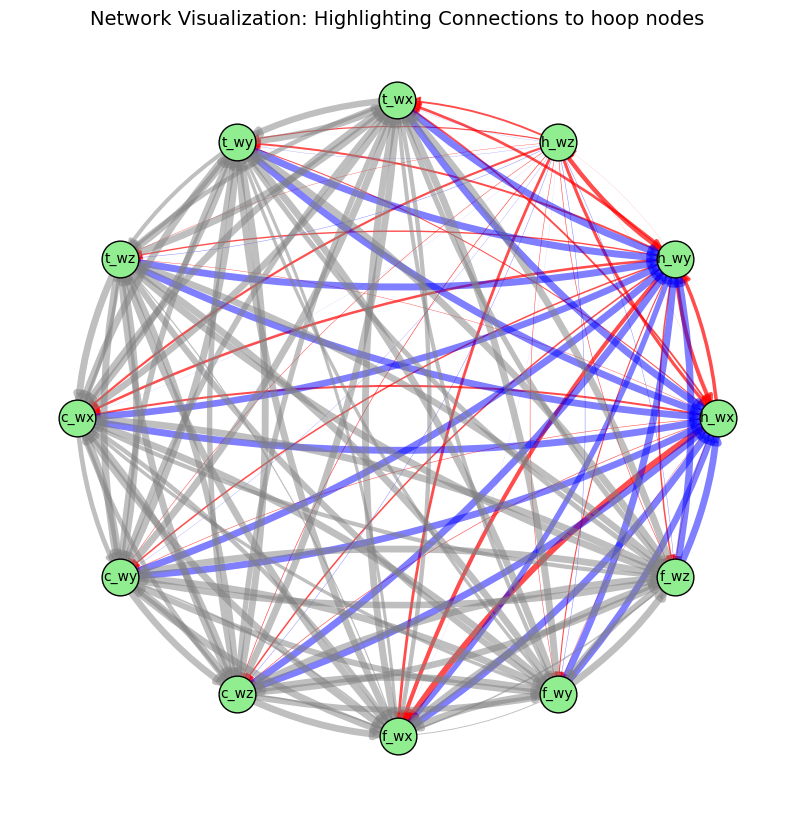

<Figure size 640x480 with 0 Axes>

In [11]:
plot_ang_vel = plot_network(networks['ang_vel']['C_xys'], mapping_w, target_nodes_w)

In [12]:
animate_networks(data_ang_vel, mapping_w, target_nodes_w, animation_filename='network_evolution_ang_vel.gif')

Generating animation with 80 frames...
Animation saved as network_evolution_ang_vel.gif


## Linear phase space (2 components per node: linear displacement and velocity)

In [13]:
data_lin_phase = scale_data_array(data_dict_to_3d_array(data_dict,
                                                        sensors=['OR','IT','IL','IB'],
                                                        quantities=[['dx','vx'],['dy','vy'],['dz','vz']],
                                                        ntime=500))
np.shape(data_lin_phase)

(500, 12, 2)

In [14]:
with redirect_stdout(io.StringIO()):
    network_l = compute_functional_network(data_lin_phase,(0.06, 0.06, 0.02),
                                           C_threshold=0.02,
                                           T_threshold=0.02,
                                           n=np.shape(data_lin_phase)[1])
for i,q in enumerate(network_quantities):
    networks['lin_phase'][q] = network_l[i]

mapping_l = {
    0: "h_dx", 1:  "h_dy", 2:  "h_dz", 
    3: "t_dx", 4:  "t_dy", 5:  "t_dz", 
    6: "c_dx", 7:  "c_dy", 8:  "c_dz", 
    9: "f_dx", 10: "f_dy", 11: "f_dz"
}
target_nodes_l = ["h_dx", "h_dy", "h_dz"]

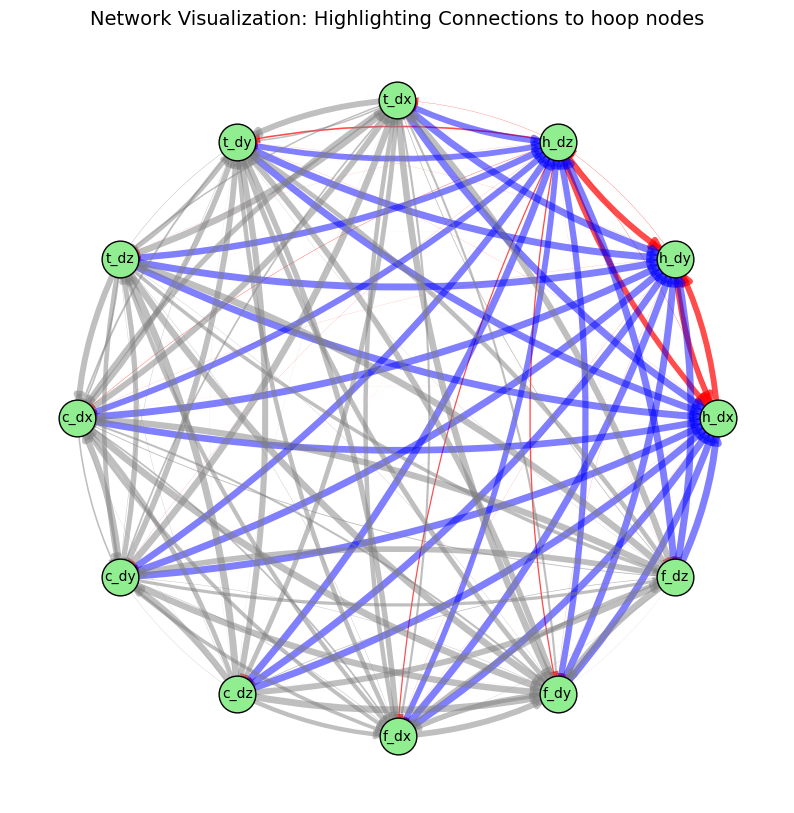

<Figure size 640x480 with 0 Axes>

In [15]:
plot_lin_phase = plot_network(networks['lin_phase']['C_xys'], mapping_l, target_nodes_l)

In [16]:
animate_networks(data_lin_phase, mapping_l, target_nodes_l, animation_filename='network_evolution_lin_phase.gif')

Generating animation with 80 frames...
Animation saved as network_evolution_lin_phase.gif


## Euler phase space (2 components per node: euler angle and angular velocity)

In [17]:
data_ang_phase = scale_data_array(data_dict_to_3d_array(data_dict,
                                                        sensors=['OR','IT','IL','IB'],
                                                        quantities=[['phi','wx'],['theta','wy'],['psi','wz']],
                                                        ntime=500))
np.shape(data_ang_phase)

(500, 12, 2)

In [18]:
with redirect_stdout(io.StringIO()):
    network_e = compute_functional_network(data_ang_phase,(0.06, 0.06, 0.02),
                                           C_threshold=0.02,
                                           T_threshold=0.02,
                                           n=np.shape(data_ang_phase)[1])
for i,q in enumerate(network_quantities):
    networks['ang_phase'][q] = network_e[i]

mapping_e = {
    0: "h_phi", 1:  "h_theta", 2:  "h_psi", 
    3: "t_phi", 4:  "t_theta", 5:  "t_psi", 
    6: "c_phi", 7:  "c_theta", 8:  "c_psi", 
    9: "f_phi", 10: "f_theta", 11: "f_psi"
}
target_nodes_e = ["h_phi", "h_theta", "h_psi"]

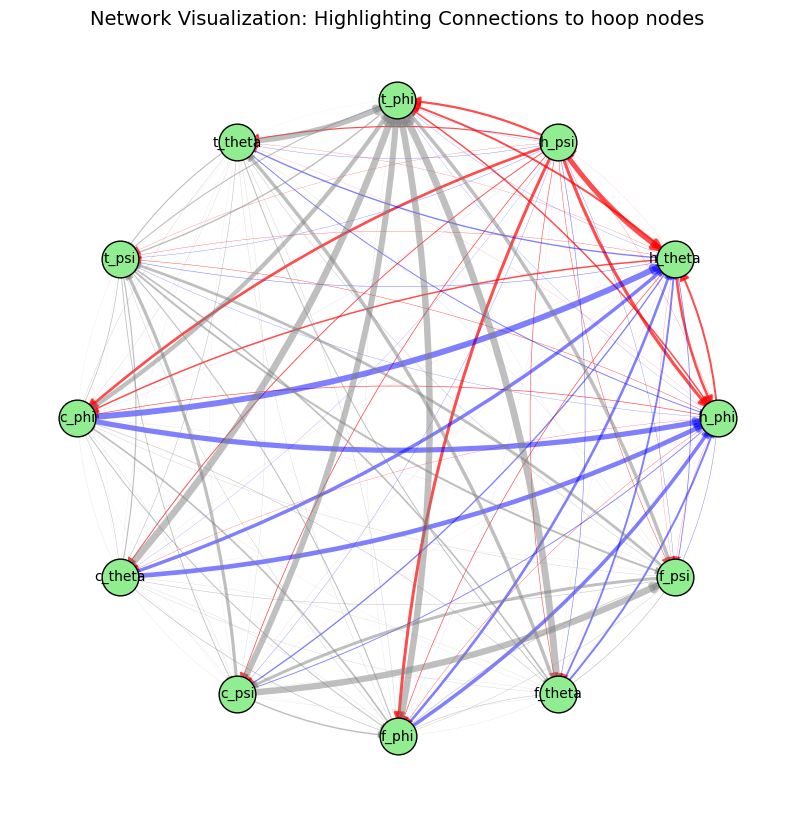

<Figure size 640x480 with 0 Axes>

In [19]:
plot_ang_phase = plot_network(networks['ang_phase']['C_xys'], mapping_e, target_nodes_e)

In [20]:
animate_networks(data_ang_phase, mapping_e, target_nodes_e, animation_filename='network_evolution_ang_phase.gif')

Generating animation with 80 frames...
Animation saved as network_evolution_ang_phase.gif
